In [2]:
import uuid
import glob
import base64
import requests
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import ImageFile, Image
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
print("Tensorflow version: ", tf.__version__)
print("Pandas version: ", pd.__version__)
print("Numpy version: ", np.__version__)

Tensorflow version:  2.10.1
Pandas version:  2.2.3
Numpy version:  1.24.3


In [4]:
gpus= tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

Num GPUs Available:  0


In [5]:
# check there is currpted image
def is_corrupted_image(image_path):
    try:
        img = Image.open(image_path) # open the image file
        img.verify() # verify that it is, in fact an image
        return False
    
    except (IOError, SyntaxError) as e:
        print('Bad file:', image_path) # print out the names of corrupt files

for image_path in glob.glob("data/body/*/*.*"):
    is_corrupted_image(image_path)

In [6]:
def preprocessing_function(image):
    return tf.keras.applications.xception.preprocess_input(image)
    
def load_image_data_generator(train_path: str = 'data/body'):
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                                    zoom_range=0.2,
                                                                    shear_range=0.2,
                                                                    rotation_range=20,
                                                                    width_shift_range=0.2,
                                                                    height_shift_range=0.2,
                                                                    horizontal_flip=True,
                                                                    validation_split=0.3,
                                                                    preprocessing_function=preprocessing_function,
                                                                    )
    train_generator = train_datagen.flow_from_directory(
                                                        train_path,
                                                        batch_size=12,
                                                        color_mode='rgb',
                                                        target_size=(224, 224),
                                                        class_mode='categorical',
                                                        subset='training'
                                                        )   

    test_generator = train_datagen.flow_from_directory(
                                                    train_path,
                                                    batch_size=12,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    class_mode='categorical',
                                                    subset='validation'                         
                                                    )   

    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                                    zoom_range=0.2,
                                                                    shear_range=0.2,
                                                                    rotation_range=20,
                                                                    width_shift_range=0.2,
                                                                    height_shift_range=0.2,
                                                                    horizontal_flip=True,
                                                                    preprocessing_function=preprocessing_function,
                                                                    )

    train_generator = train_datagen.flow_from_directory(
                                                        train_path,
                                                        batch_size=12,
                                                        color_mode='rgb',
                                                        target_size=(224, 224),
                                                        class_mode='categorical'
                                                        )   
    return train_generator, test_generator

In [7]:
train_generator, test_generator = load_image_data_generator()

Found 1832 images belonging to 5 classes.
Found 782 images belonging to 5 classes.
Found 2614 images belonging to 5 classes.


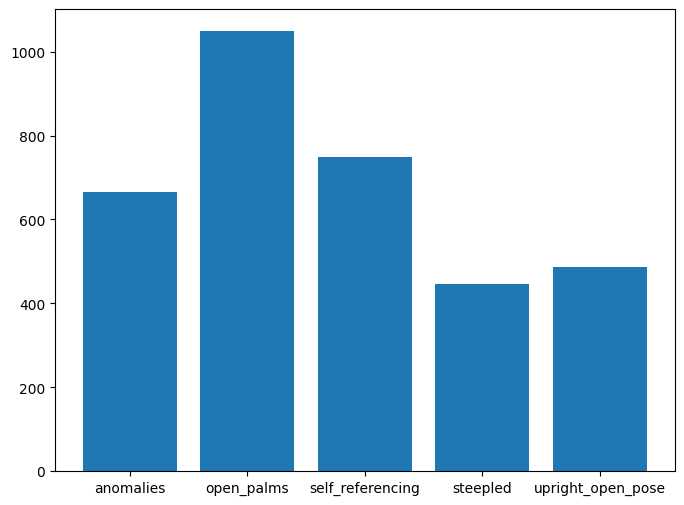

In [8]:
labels = train_generator.classes.tolist() + test_generator.classes.tolist()
value_counts = np.unique(labels, return_counts=True)

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(value_counts[0], value_counts[1])
ax.set_xticks(value_counts[0])
ax.set_xticklabels(list(train_generator.class_indices.keys()))
plt.show()

In [9]:
def build_model(input_shape=(224, 224, 3)):
        xception_model = tf.keras.applications.Xception(
                                                        include_top=False,
                                                        weights='imagenet',
                                                        input_shape=input_shape
                                                        )
        xception_model.trainable = True

        input_layer = tf.keras.layers.Input(shape=input_shape)
        x = xception_model(input_layer)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(512, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        output_layer = tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')(x)

        model = tf.keras.Model(
                                inputs=input_layer, 
                                outputs=output_layer
                                )

        model.compile(
                        optimizer='adam', 
                        loss='categorical_crossentropy', 
                        metrics=[
                                tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                                tf.keras.metrics.Precision(name='precision'),
                                tf.keras.metrics.Recall(name='recall'),
                                tf.keras.metrics.AUC(name='auc')
                                ]
                        )

        return model

In [10]:
model = build_model()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                             

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                                                patience=50,
                                                monitor='val_loss',
                                                restore_best_weights=True
                                                )   

history = model.fit(
                    train_generator, epochs=200,
                    validation_data = test_generator,
                    callbacks = [early_stopping]
                    )

In [11]:
model.save('artifacts/model_body.h5')

In [ ]:
history_cp = history.history.copy()
history_cp['loss'] = np.cumsum(history_cp['loss']) / np.arange(1, len(history_cp['loss']) + 1)
history_cp['val_loss'] = np.cumsum(history_cp['val_loss']) / np.arange(1, len(history_cp['val_loss']) + 1)

history_cp['accuracy'] = np.cumsum(history_cp['accuracy']) / np.arange(1, len(history_cp['accuracy']) + 1)
history_cp['val_accuracy'] = np.cumsum(history_cp['val_accuracy']) / np.arange(1, len(history_cp['val_accuracy']) + 1)

history_cp['precision'] = np.cumsum(history_cp['precision']) / np.arange(1, len(history_cp['precision']) + 1)
history_cp['val_precision'] = np.cumsum(history_cp['val_precision']) / np.arange(1, len(history_cp['val_precision']) + 1)

history_cp['recall'] = np.cumsum(history_cp['recall']) / np.arange(1, len(history_cp['recall']) + 1)
history_cp['val_recall'] = np.cumsum(history_cp['val_recall']) / np.arange(1, len(history_cp['val_recall']) + 1)

history_cp['auc'] = np.cumsum(history_cp['auc']) / np.arange(1, len(history_cp['auc']) + 1)
history_cp['val_auc'] = np.cumsum(history_cp['val_auc']) / np.arange(1, len(history_cp['val_auc']) + 1)

In [ ]:
# Plot history_cp
plt.figure(figsize=(25, 5))
plt.subplot(1, 5, 1)
plt.plot(history_cp['loss'], label='loss')
plt.plot(history_cp['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 5, 2)
plt.plot(history_cp['accuracy'], label='accuracy')
plt.plot(history_cp['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 5, 3)
plt.plot(history_cp['precision'], label='precision')
plt.plot(history_cp['val_precision'], label='val_precision')
plt.legend()
plt.title('Precision')

plt.subplot(1, 5, 4)
plt.plot(history_cp['recall'], label='recall')
plt.plot(history_cp['val_recall'], label='val_recall')
plt.legend()
plt.title('Recall')

plt.subplot(1, 5, 5)
plt.plot(history_cp['auc'], label='auc')
plt.plot(history_cp['val_auc'], label='val_auc')
plt.legend()
plt.title('AUC')

plt.suptitle('Emotion Model - Training Performance')
plt.show()

### Evaluation

In [12]:
import cv2 as cv
import numpy as np
import seaborn as sns
import tensorflow as tf
from PIL import ImageFile
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [23]:
model = tf.keras.models.load_model('artifacts/model_body.h5')
model.compile(
                optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=[
                        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc')
                        ]
                )

In [14]:
def preprocessing_function(image):
    return tf.keras.applications.xception.preprocess_input(image)
    
def inference_animal(image_path):
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    image = preprocessing_function(image)
    pred = model.predict(
                        image,
                        verbose=0
                        ).squeeze()
    label = pred.argmax()
    return label

In [24]:
eval_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                                preprocessing_function=preprocessing_function,
                                                                )
eval_generator = eval_datagen.flow_from_directory(
                                                'data/body',
                                                batch_size=32,
                                                color_mode='rgb',
                                                target_size=(224, 224),
                                                class_mode='categorical'   ,
                                                shuffle=False                  
                                                )   


Found 2614 images belonging to 5 classes.


In [25]:
Ptest = model.predict(eval_generator)
Ptest = Ptest.argmax(axis=1)

82/82 [==============================] - 192s 2s/step


In [26]:
class_dict = eval_generator.class_indices
class_dict_rev = {v: k for k, v in class_dict.items()}
class_dict_rev

{0: 'anomalies',
 1: 'open_palms',
 2: 'self_referencing',
 3: 'steepled',
 4: 'upright_open_pose'}

In [27]:
img_paths = eval_generator.filepaths
img_paths = [img_path.replace('\\', '/') for img_path in img_paths]
Ytest = [class_dict[img_path.split('/')[-2]] for img_path in img_paths]

In [28]:
clf_report = classification_report(
                                    Ytest,
                                    Ptest,
                                    target_names=list(class_dict.keys())    
                                    )   
cm = confusion_matrix(Ytest, Ptest)

In [29]:
print("############### Classification Report ###############")
print(clf_report)

############### Classification Report ###############
                   precision    recall  f1-score   support

        anomalies       0.20      0.42      0.27       512
       open_palms       0.22      0.18      0.20       807
 self_referencing       0.12      0.01      0.02       576
         steepled       0.09      0.09      0.09       344
upright_open_pose       0.07      0.09      0.08       375

         accuracy                           0.16      2614
        macro avg       0.14      0.16      0.13      2614
     weighted avg       0.15      0.16      0.14      2614



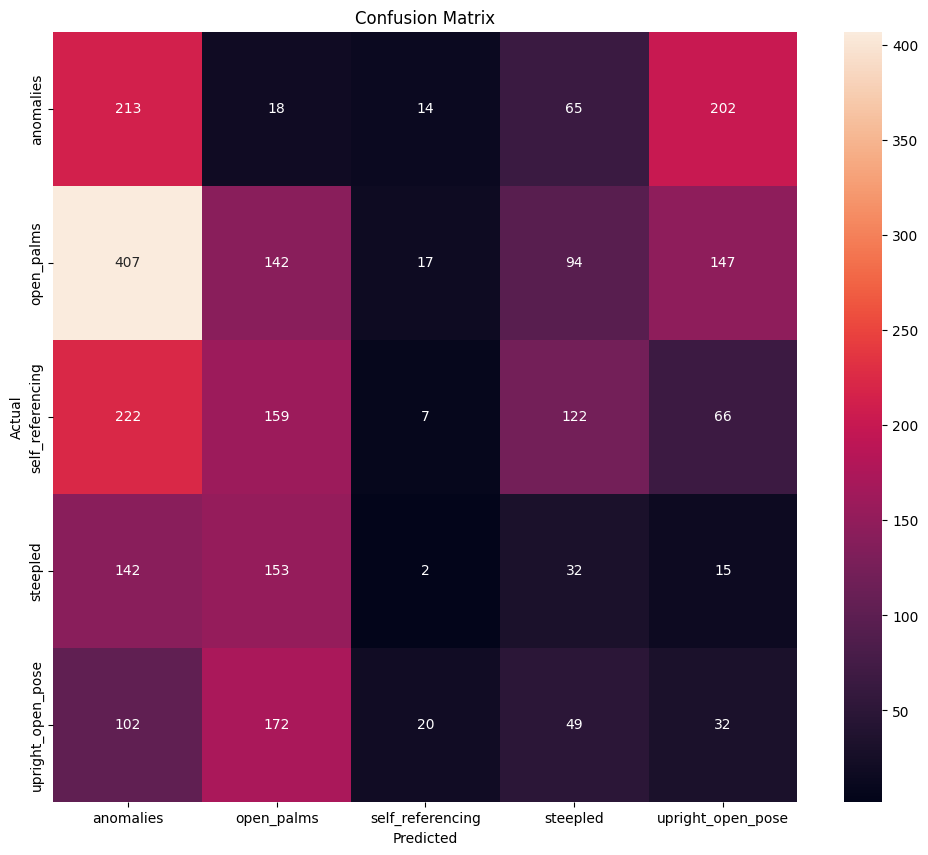

In [30]:
plt.figure(figsize=(12, 10))
sns.heatmap(
            cm, 
            fmt='d', 
            annot=True, 
            xticklabels=list(class_dict.keys()), 
            yticklabels=list(class_dict.keys())
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Inference

In [31]:
import cv2 as cv
import numpy as np
import pandas as pd
import tensorflow as tf

In [32]:
model = tf.keras.models.load_model('artifacts/model_body.h5')
model.compile(
                optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=[
                        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc')
                        ]
                )

In [34]:
def inference_body_image(
                    image_path,
                    class_dict = {
                                0: 'anomalies',
                                1: 'open_palms',
                                2: 'self_referencing',
                                3: 'steepled',
                                4: 'upright_open_pose'
                                }
                    ):
        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = cv.resize(image, (224, 224))
        image = np.expand_dims(image, axis=0)
        image = tf.keras.applications.xception.preprocess_input(image)
        pred = model_disease.predict(
                                    image,
                                    verbose=0
                                    ).squeeze()
        label = int(pred.argmax())
        return class_dict[label]

In [35]:
inference_body_image('data/body/anomalies/Dananjaya Hettiarachchi World Champion of Public Speaking 2014 Full Speech_000434.jpg')

'anomalies'

In [36]:
def inference_body_video(
                    video_path,
                    class_dict = {
                                0: 'anomalies',
                                1: 'open_palms',
                                2: 'self_referencing',
                                3: 'steepled',
                                4: 'upright_open_pose'
                                },
                    score_dict = {
                                "steepled": 0.4,
                                "anomalies": 0,
                                "open_palms": 0.3,
                                "self_referencing": 0.2,
                                "upright_open_pose": 0.1
                                },
                    is_visualize = False
                    ):
        result_dict = {}
        for key in class_dict.values():
            result_dict[key] = 0

        frame_count = 0
        cap = cv.VideoCapture(video_path)
        FPS = int(cap.get(cv.CAP_PROP_FPS))
        print("Frames per second using video.get(cv.CAP_PROP_FPS) : {0}".format(FPS))

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if frame_count % FPS == 0:
                image = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
                image = cv.resize(image, (224, 224))
                image = np.expand_dims(image, axis=0)
                image = tf.keras.applications.xception.preprocess_input(image)
                pred = model.predict(
                                            image,
                                            verbose=0
                                            ).squeeze()
                label = int(pred.argmax())
                proba = round(pred[label] * 100, 2)
                result_dict[class_dict[label]] += 1

                if is_visualize:
                    color = (0, 0, 255) if label != "anomalies" else (255, 0, 0)
                    cv.putText(
                                frame, 
                                f"CLASS : {class_dict[label]}",
                                (10, 30), 
                                cv.FONT_HERSHEY_SIMPLEX, 
                                1, 
                                color, 
                                2
                                )
                    cv.putText(
                                frame, 
                                f"CONFIDENCE : {proba} %",
                                (10, 60), 
                                cv.FONT_HERSHEY_SIMPLEX, 
                                1, 
                                color, 
                                2
                                )
                    cv.imshow('frame', frame)
                    if cv.waitKey(1) & 0xFF == ord('q'):
                        break

            frame_count += 1

        cap.release()

        df = pd.DataFrame(result_dict, index=[0])
        df_avg = df / df.sum(axis=1).values[0]
        df_perc = df_avg * 100
        response = df_perc.to_dict(orient='records')
        final_score = sum([score_dict[key] * value for key, value in response[0].items()])
        final_score = f"{round(final_score, 2)} %" 
        response = {key : f"{value} %" for key, value in response[0].items()}
        return response, final_score

In [39]:
response, final_score = inference_body_video('test_data/positive/test.mp4', is_visualize=True)
print(response)
print(final_score)

Frames per second using video.get(cv.CAP_PROP_FPS) : 30
{'anomalies': '75.0 %', 'open_palms': '0.0 %', 'self_referencing': '0.0 %', 'steepled': '25.0 %', 'upright_open_pose': '0.0 %'}
10.0 %


In [41]:
response, final_score = inference_body_video('test_data/positive/test.mp4', is_visualize=False)
print(f"Body Language : {response}")
print(f"Final Score : {final_score}")

Frames per second using video.get(cv.CAP_PROP_FPS) : 30
Body Language : {'anomalies': '75.0 %', 'open_palms': '0.0 %', 'self_referencing': '0.0 %', 'steepled': '25.0 %', 'upright_open_pose': '0.0 %'}
Final Score : 10.0 %
